<a href="https://colab.research.google.com/github/AbdulQadir8/Lung-Cancer-Detection/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

In [1]:
import os
import shutil
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import load_model

from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

#from tensorflow.keras.models import load_model # !!!!!!!!!!!!!!!! import models already

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Input
from tensorflow.keras import Model

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Create the directory structure for a dataset.

train (all of the data is in this folder)

lung cancer dataset

train

negative
positive
validation

negative
positive
test

negative
positive

In [ ]:
import splitfolders

# Define the path to your data folders on Google Drive
input_folder = "/content/drive/MyDrive/Datasets/lung_cancer_dataset"  # Update this with your actual folder path
output_folder = "/content/drive/MyDrive/Datasets/d_lung_cancer_datatset"  # Update this with your desired output folder path

# Define the split ratios
split_ratios = (0.6, 0.2, 0.2)  # Train, validation, test

# Use splitfolders to perform the data split
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=split_ratios, group_prefix=None)

print("Data splitting complete.")

Copying files: 534 files [03:44,  2.38 files/s]

Data splitting complete.


In [ ]:
len(os.listdir("/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train/negative"))

180

In [ ]:
print('total training +ive images:'              , len(os.listdir('/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train/positive')))
print('total training -ive images:'              , len(os.listdir('/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train/negative')))
print('\n')

print('total validation +ive images:'            , len(os.listdir('/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/val/positive')))
print('total validation -ive images:'            , len(os.listdir('/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/val/negative')))
print('\n')

print('total test +ive images:'                  , len(os.listdir('/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test/positive')))
print('total test -ive images:'                  , len(os.listdir('/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test/negative')))


total training +ive images: 140
total training -ive images: 180


total validation +ive images: 46
total validation -ive images: 61


total test +ive images: 48
total test -ive images: 48


### Data preprocessing - Without Data Augmentation

All of the following things are handled by **ImageDataGenerator** from Keras:
- Reading the picture files.
- Decoding the JPEG content to RGB grids of pixels.
- Converting these into floating-point tensors.
- Rescaling the pixel values (between 0 and 255) to the [0, 1] interval (as we know, neural networks prefer to deal with small input values).

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator: specially designed for image data

train_dir = "/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train"
validation_dir = "/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/val"
test_dir = "/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test"

gen = ImageDataGenerator(rescale=1./255)


train_generator = gen.flow_from_directory(
                                          train_dir,
                                          target_size = (200,200),
                                          batch_size = 15,
                                          class_mode = 'binary')

validation_generator = gen.flow_from_directory(validation_dir,
                                               target_size = (200,200),
                                               batch_size = 15,
                                               class_mode = 'binary')

test_generator = gen.flow_from_directory(test_dir,
                                         target_size = (200,200),
                                         batch_size = 15,
                                         class_mode = 'binary')

Found 320 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


# Instantiating a small convnet

In [ ]:
# from tensorflow.keras import layers
# from tensorflow.keras import models

model = models.Sequential()

# Convolutional base
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200, 3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Classifier Base
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-4),
              metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

### Setting up call backs

In [ ]:
# creating the folder 'models'
# in this folder we'll save the weights of our model after each epoch

models  =  '/content/models'
os.mkdir(models)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import callbacks

# The sets-of-weights at d/f epochs will have d/f names
checkpoint_path = '/content/models/cp-{epoch:04d}.ckpt'

# converting it into a directory
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback = callbacks.ModelCheckpoint(checkpoint_path, verbose = 1, save_weights_only = True)

# For details and much more, see this official video from tensorflow
# https://www.youtube.com/watch?v=HxtBIwfy0kM


In [ ]:
history = model.fit(train_generator,
                    epochs            =  30,
                    validation_data   =  validation_generator,
                    callbacks         =  cp_callback
                  )

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.6874 - acc: 0.5719
Epoch 1: saving model to /content/models/cp-0001.ckpt
22/22 [==============================] - 178s 8s/step - loss: 0.6874 - acc: 0.5719 - val_loss: 0.6877 - val_acc: 0.5660
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.6665 - acc: 0.6219
Epoch 2: saving model to /content/models/cp-0002.ckpt
22/22 [==============================] - 5s 214ms/step - loss: 0.6665 - acc: 0.6219 - val_loss: 0.6328 - val_acc: 0.5660
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.5999 - acc: 0.7094
Epoch 3: saving model to /content/models/cp-0003.ckpt
22/22 [==============================] - 6s 259ms/step - loss: 0.5999 - acc: 0.7094 - val_loss: 0.5414 - val_acc: 0.8019
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.5266 - acc: 0.7563
Epoch 4: saving model to /content/models/cp-0004.ckpt
22/22 [==============================] - 5s 209ms/step - loss: 0.5

In [ ]:
model.save("lung_cancer_simple.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Copy the entire folder and its contents recursively

source_folder       = '/content/models'
destination_folder  = '/content/drive/MyDrive/google colab/lung cancer simple model cps'

copy_folder_contents(source_folder, destination_folder)

Contents of '/content/models' copied to '/content/drive/MyDrive/google colab/lung cancer simple model cps' successfully.


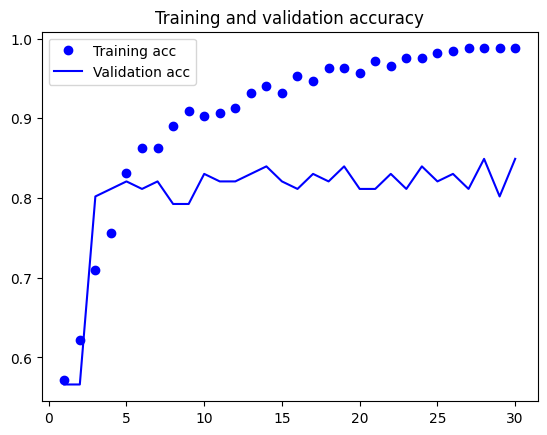

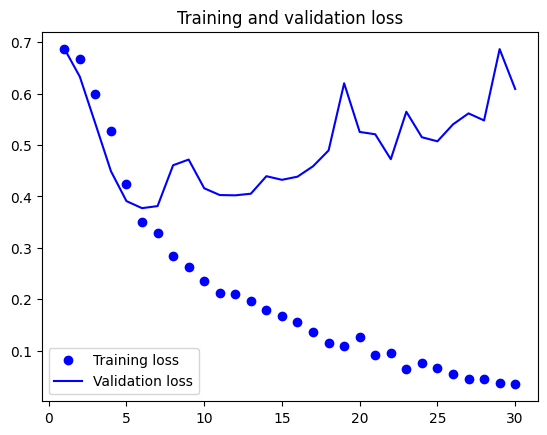

In [ ]:
# Plotting the results
plot_training_history(history)

In [ ]:
if __name__ == "__main__":
    checkpoint_folder = "/content/models"

    # Load your pre-built model here
    model = load_model('/content/lung_cancer_simple.h5')  # Replace with the path to your model

    # Replace these with your actual test and validation generators
    test_generator = test_generator
    validation_generator = validation_generator

    results_df = evaluate_checkpoints(checkpoint_folder, model, test_generator, validation_generator)
    results_df


8/8 [==============================] - 2s 185ms/step - loss: 0.2384 - acc: 0.8796


In [ ]:
results_df.sort_values(by="Checkpoint", ascending=True)

,Checkpoint,Validation Loss,Validation Accuracy,Test Loss,Test Accuracy
9,cp-0001.ckpt.index,0.687711,0.566038,0.688370,0.555556
4,cp-0002.ckpt.index,0.632819,0.566038,0.623732,0.555556
23,cp-0003.ckpt.index,0.541449,0.801887,0.513610,0.861111
5,cp-0004.ckpt.index,0.449077,0.811321,0.407549,0.861111
8,cp-0005.ckpt.index,0.390764,0.820755,0.329664,0.861111
14,cp-0006.ckpt.index,0.377061,0.811321,0.291391,0.907407
18,cp-0007.ckpt.index,0.381071,0.820755,0.284902,0.870370
26,cp-0008.ckpt.index,0.460535,0.792453,0.350464,0.824074
20,cp-0009.ckpt.index,0.471597,0.792453,0.334938,0.824074
25,cp-0010.ckpt.index,0.415748,0.830189,0.258126,0.916667


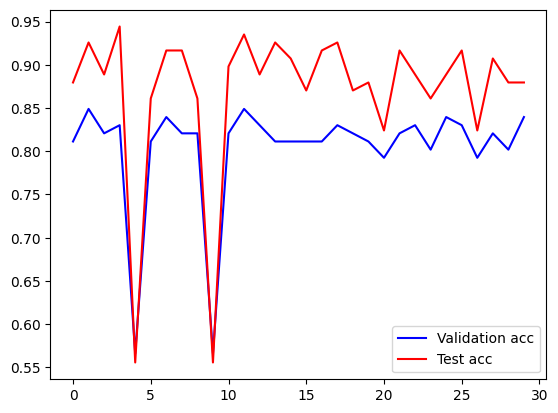

In [ ]:
plot_validation_and_test_accuracy(results_df)

In [ ]:
# Loading the best set of weights
best = "/content/models/cp-0030.ckpt"
model.load_weights(best)

In [ ]:
# Testing the model on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

8/8 [==============================] - 1s 139ms/step - loss: 0.2722 - acc: 0.9352
test acc: 0.9351851940155029


# Classification Report

# Undersampling the positive images test split

In [ ]:
source_folder       =  '/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test/negative'
destination_folder  =  '/content/lung cancer dataset/temporary'
num_files_to_move   =  12  # Change this to the desired number of files to move

move_files(source_folder, destination_folder, num_files_to_move)



Moved: person100_bacteria_479.jpeg
Moved: person102_bacteria_487.jpeg
Moved: person103_bacteria_488.jpeg
Moved: person103_bacteria_489.jpeg
Moved: person104_bacteria_491.jpeg
Moved: person104_bacteria_492.jpeg
Moved: person108_bacteria_504.jpeg
Moved: person108_bacteria_511.jpeg
Moved: person109_bacteria_513.jpeg
Moved: person11_virus_38.jpeg
Moved: person139_bacteria_665.jpeg
Moved: person141_bacteria_670.jpeg


In [ ]:
# New test generator
# from sklearn.metrics import classification_report

test_generator       = gen.flow_from_directory(
                                                '/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test',
                                                target_size      =  (200, 200),
                                                batch_size       =  96,
                                                class_mode       =  'binary')

batch, true_labels         =  next(test_generator)
predicted_probabilities    =  model.predict(batch)
predicted_labels = (predicted_probabilities > 0.5).astype(int).reshape(96,1)

# Generating the classification report
report = classification_report(true_labels, predicted_labels)

print(report)


Found 96 images belonging to 2 classes.
3/3 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.92        48
         1.0       0.90      0.96      0.93        48

    accuracy                           0.93        96
   macro avg       0.93      0.93      0.93        96
weighted avg       0.93      0.93      0.93        96



# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

In [ ]:
print(conf_matrix.shape)

(2, 2)


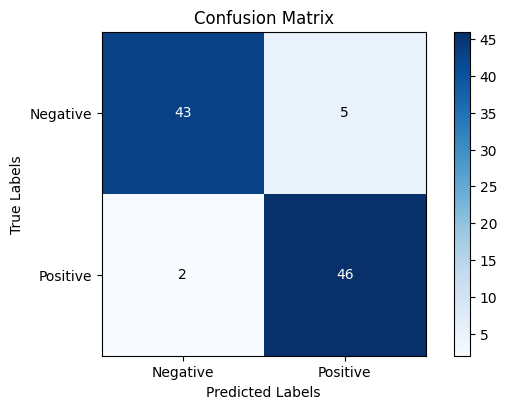

In [ ]:
plot_confusion_matrix(conf_matrix, class_labels)


In [ ]:
conf_matrix

array([[43,  5],
       [ 2, 46]])

# With Data Augmentation

In [ ]:
# I have manually done undersampling on positive training images, to nullify class imbalance
# I have moved first 12 (positive1, 2, 3 , ..14) images to a temporay folder 'lung cancer dataset/ tempporary for positive train....'


In [ ]:
print('total training +ive images:'              , len(os.listdir(r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train/positive')))
print('total training -ive images:'              , len(os.listdir(r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train/negative')))
print('\n')

print('total validation +ive images:'            , len(os.listdir(r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/val/positive')))
print('total validation -ive images:'            , len(os.listdir(r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/val/negative')))
print('\n')

print('total test +ive images:'                  , len(os.listdir(r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test/positive')))
print('total test -ive images:'                  , len(os.listdir(r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test/negative')))


total training +ive images: 140
total training -ive images: 180


total validation +ive images: 46
total validation -ive images: 61


total test +ive images: 48
total test -ive images: 48


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator: specially designed for image data

train_dir       =  r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train'
validation_dir  =  r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/val'
test_dir        =  r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/test'


train_datagen = ImageDataGenerator(
                    rescale             =  1./255,
                    rotation_range      =  10,
                    width_shift_range   =  0.1,
                    height_shift_range  =  0.1,
                    shear_range         =  0.1,
                    zoom_range          =  0.1,
                    horizontal_flip     =  True,)



test_datagen   = ImageDataGenerator(rescale = 1./255) # Validation data ko augment nahi kr rahay


train_generator      = train_datagen.flow_from_directory(
                        train_dir,
                        target_size  =  (200, 200),
                        batch_size   =  15,
                        class_mode   =  'binary')

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size  =  (200, 200),
                        batch_size   =  15,
                        class_mode   =  'binary')

test_generator       = test_datagen.flow_from_directory(
                        test_dir,
                        target_size  =  (200, 200),
                        batch_size   =  15,
                        class_mode   =  'binary')


Found 320 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [2]:
# from tensorflow.keras import layers
# from tensorflow.keras import models

model = models.Sequential()

# Convolutional Base
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Classifier Base
model.add(layers.Flatten())
#model.add(layers.Dropout(0.1)) # Dropout layer lga di
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(loss       =  'binary_crossentropy',
              optimizer  =  optimizer,
              metrics    =  ['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 128)       0

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import callbacks

# The sets-of-weights at d/f epochs will have d/f names
checkpoint_path = '/content/drive/MyDrive/google colab/data_augmentation_cps/cp-{epoch:04d}.ckpt'

# converting it into a directory
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback = callbacks.ModelCheckpoint(checkpoint_path, verbose = 1, save_weights_only = True)

# For details and much more, see this official video from tensorflow
# https://www.youtube.com/watch?v=HxtBIwfy0kM


In [ ]:
history = model.fit(train_generator,
                    epochs            =  30,
                    validation_data   =  validation_generator,
                    callbacks         =  cp_callback
                  )


Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.7059 - acc: 0.5000
Epoch 1: saving model to /content/drive/MyDrive/google colab/data_augmentation_cps/cp-0001.ckpt
22/22 [==============================] - 12s 419ms/step - loss: 0.7059 - acc: 0.5000 - val_loss: 0.6880 - val_acc: 0.5660
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.6886 - acc: 0.5625
Epoch 2: saving model to /content/drive/MyDrive/google colab/data_augmentation_cps/cp-0002.ckpt
22/22 [==============================] - 8s 362ms/step - loss: 0.6886 - acc: 0.5625 - val_loss: 0.6786 - val_acc: 0.5660
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.6373 - acc: 0.5844
Epoch 3: saving model to /content/drive/MyDrive/google colab/data_augmentation_cps/cp-0003.ckpt
22/22 [==============================] - 8s 353ms/step - loss: 0.6373 - acc: 0.5844 - val_loss: 0.6773 - val_acc: 0.6038
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.6207 - acc:

In [ ]:
model.save('lung_cancer_simple_augmented.h5')

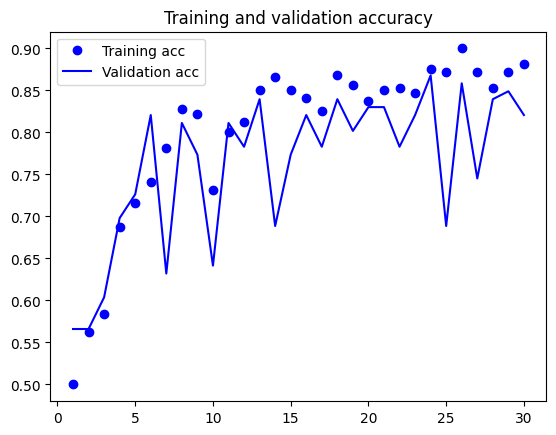

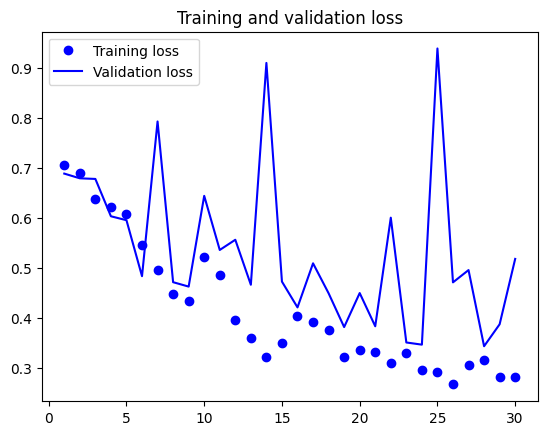

In [ ]:
plot_training_history(history)

In [ ]:
if __name__ == "__main__":
    checkpoint_folder = r"/content/drive/MyDrive/google colab/data_augmentation_cps"

    # Load your pre-built model here
    model = load_model('lung_cancer_simple_augmented.h5')  # Replace with the path to your model


    test_generator       = test_generator
    validation_generator = validation_generator

    results_df = evaluate_checkpoints(checkpoint_folder, model, test_generator, validation_generator)
    results_df

7/7 [==============================] - 1s 129ms/step - loss: 0.2934 - acc: 0.8854


In [ ]:
results_df.sort_values(by="Checkpoint", ascending=True)

,Checkpoint,Validation Loss,Validation Accuracy,Test Loss,Test Accuracy
0,cp-0001.ckpt.index,0.687994,0.566038,0.698503,0.500000
1,cp-0002.ckpt.index,0.678588,0.566038,0.699541,0.500000
2,cp-0003.ckpt.index,0.677315,0.603774,0.688894,0.614583
3,cp-0004.ckpt.index,0.602672,0.698113,0.592947,0.645833
4,cp-0005.ckpt.index,0.594810,0.726415,0.581363,0.697917
5,cp-0006.ckpt.index,0.482875,0.820755,0.378614,0.895833
6,cp-0007.ckpt.index,0.792227,0.632075,0.433888,0.750000
7,cp-0008.ckpt.index,0.470881,0.811321,0.230166,0.916667
8,cp-0009.ckpt.index,0.462075,0.773585,0.320287,0.895833
9,cp-0010.ckpt.index,0.643496,0.641509,0.594657,0.770833


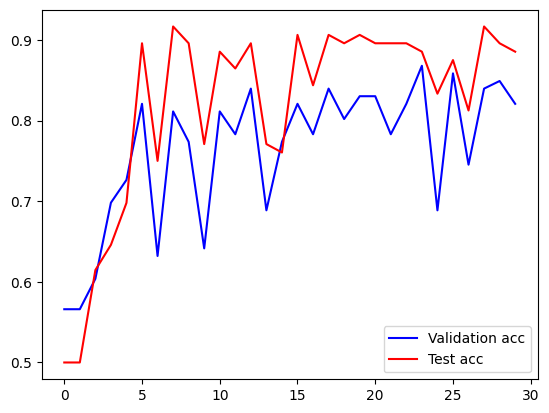

In [ ]:
plot_validation_and_test_accuracy(results_df)


In [3]:
# Loading the best set of weights
best = r'/content/drive/MyDrive/google colab/data_augmentation_cps/cp-0024.ckpt'
model.load_weights(best)


In [4]:
model.save("simple_augmented_with_best_weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Testing the model on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)


7/7 [==============================] - 1s 137ms/step - loss: 0.2361 - acc: 0.8854
test acc: 0.8854166865348816


We choose the 21st checkpoint because the overfitting is likely to be less in it.

The confusion matrices produced by this checkpoint are better than all of the other checkpoints.

### Classification Report

#### Undersampling the positive images test split

this time I did it without using code (because I am now running the notebok on pc)

moved positive189,190,191,192 from test/positive folder to the 'lung cancer dataset/temporary folder'


In [ ]:
# New test generator
# from sklearn.metrics import classification_report
test_generator       = test_datagen.flow_from_directory(
                                                r'/content/drive/MyDrive/Datasets/d_lung_cancer_datatset/train',
                                                target_size      =  (200, 200),
#                                                batch_size       =  88,
                                                batch_size       =  96,
                                                class_mode       =  'binary')

batch, true_labels         =  next(test_generator)
predicted_probabilities    =  model.predict(batch)
#predicted_labels = (predicted_probabilities > 0.5).astype(int).reshape(88,1)
predicted_labels = (predicted_probabilities > 0.5).astype(int).reshape(96,1)


# Generating the classification report
report = classification_report(true_labels, predicted_labels)

print(report)


Found 320 images belonging to 2 classes.
3/3 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92        59
         1.0       0.89      0.84      0.86        37

    accuracy                           0.90        96
   macro avg       0.89      0.89      0.89        96
weighted avg       0.90      0.90      0.90        96



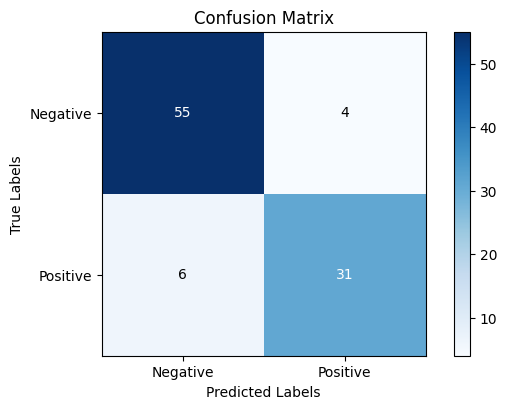

In [ ]:
# from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(conf_matrix, class_labels)

# Functional API Format

In [ ]:
# from tensorflow.keras import Input
# from tensorflow.keras import Model


inputs = Input(shape=(200, 200, 3))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

optimizer = optimizers.Adam(learning_rate=0.0007)
model.compile(loss       =  'binary_crossentropy',
              optimizer  =  optimizer,
              metrics    =  ['acc'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 46, 46, 128)       7385

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import callbacks

# The sets-of-weights at d/f epochs will have d/f names
checkpoint_path = r'/content/drive/MyDrive/google colab/functional_api_cps\cp-{epoch:04d}.ckpt'

# converting it into a directory
checkpoint_dir  = os.path.dirname(checkpoint_path)

cp_callback = callbacks.ModelCheckpoint(checkpoint_path, verbose = 1, save_weights_only = True)

# For details and much more, see this official video from tensorflow
# https://www.youtube.com/watch?v=HxtBIwfy0kM


In [ ]:
history = model.fit(train_generator,
                    epochs            =  30,
                    validation_data   =  validation_generator,
                    callbacks         =  cp_callback
                  )


Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 0.7134 - acc: 0.5000
Epoch 1: saving model to /content/drive/MyDrive/google colab/functional_api_cps\cp-0001.ckpt
22/22 [==============================] - 10s 325ms/step - loss: 0.7134 - acc: 0.5000 - val_loss: 0.6879 - val_acc: 0.5660
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 0.6729 - acc: 0.5813
Epoch 2: saving model to /content/drive/MyDrive/google colab/functional_api_cps\cp-0002.ckpt
22/22 [==============================] - 9s 390ms/step - loss: 0.6729 - acc: 0.5813 - val_loss: 0.6052 - val_acc: 0.6981
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.6350 - acc: 0.6625
Epoch 3: saving model to /content/drive/MyDrive/google colab/functional_api_cps\cp-0003.ckpt
22/22 [==============================] - 11s 502ms/step - loss: 0.6350 - acc: 0.6625 - val_loss: 0.6459 - val_acc: 0.6132
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.5734 - acc: 0.6812


In [ ]:
#D:\Career\Artificial Intelligence\PIAIC\Artificial Intelligence Engineering\Q3\Assignments\Lungs Cancer\functional_api_cps\cp-0023.ckpt
model.save('lung_cancer_simple_functional.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


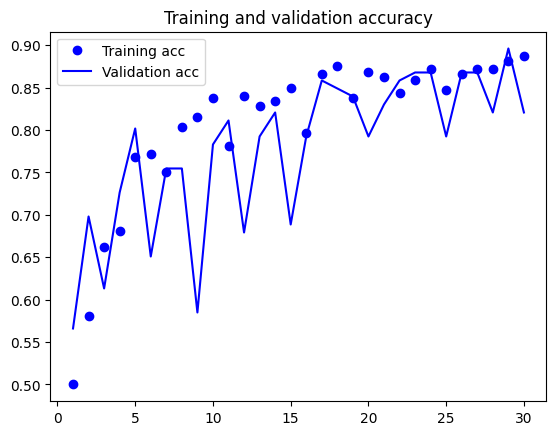

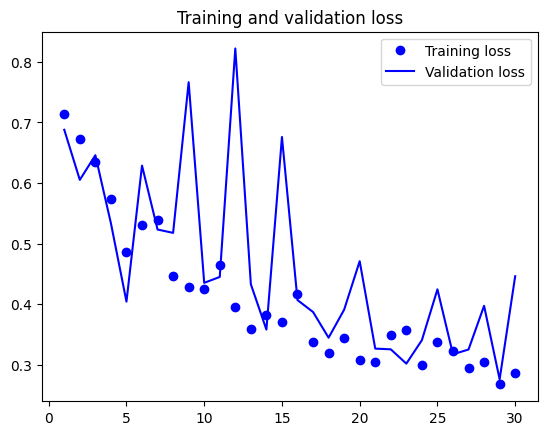

In [ ]:
plot_training_history(history)

In [ ]:
if __name__ == "__main__":
    checkpoint_folder = r"/content/drive/MyDrive/google colab/functional_api_cps"

    # Load your pre-built model here
    model = load_model('lung_cancer_simple_functional.h5')  # Replace with the path to your model


    test_generator       = test_generator
    validation_generator = validation_generator

    results_df = evaluate_checkpoints(checkpoint_folder, model, test_generator, validation_generator)
    results_df


In [ ]:
results_df.sort_values(by="Checkpoint", ascending=True)


KeyError: ignored

In [ ]:
plot_validation_and_test_accuracy(results_df)

KeyError: ignored

In [ ]:
# Loading the best set of weights
best = r'D:\Career\Artificial Intelligence\PIAIC\Artificial Intelligence Engineering\Q3\Assignments\Lungs Cancer\functional_api_cps\cp-0030.ckpt'
model.load_weights(best)


In [ ]:
# import shutil

def copy_folder_contents(source_folder, destination_folder):
    try:
        # Copy the entire folder and its contents recursively
        shutil.copytree(source_folder, destination_folder)
        print(f"Contents of '{source_folder}' copied to '{destination_folder}' successfully.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


In [ ]:
# import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation accuracy and loss from a Keras training history.

    Args:
        history (dict): A Keras training history containing 'acc', 'val_acc', 'loss', and 'val_loss' keys.

    Returns:
        None
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Example usage:
# history = {
#     'acc': [0.6, 0.7, 0.8, 0.9],
#     'val_acc': [0.5, 0.6, 0.7, 0.8],
#     'loss': [0.5, 0.4, 0.3, 0.2],
#     'val_loss': [0.6, 0.5, 0.4, 0.3]
# }


In [ ]:
# import os
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import load_model

def evaluate_checkpoints(checkpoint_folder, model, test_generator, validation_generator):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.ckpt.index')]

    results = []

    for checkpoint_file in checkpoint_files:
        checkpoint_prefix = os.path.join(checkpoint_folder, checkpoint_file[:-6])

        # Load the weights into the existing model
        model.load_weights(checkpoint_prefix)

        # Compile the model (if necessary)
        # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Evaluate on the validation data (not test data)
        validation_loss, validation_accuracy = model.evaluate(validation_generator)

        # Evaluate on the test data
        test_loss, test_accuracy = model.evaluate(test_generator)

        results.append({
            'Checkpoint': checkpoint_file,
            'Validation Loss': validation_loss,
            'Validation Accuracy': validation_accuracy,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy
        })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    return results_df



In [ ]:
import matplotlib.pyplot as plt

def plot_validation_and_test_accuracy(results_df):
    """
    Plot validation and test accuracy from a DataFrame.

    Args:
        results_df (DataFrame): A DataFrame containing 'Validation Accuracy' and 'Test Accuracy' columns.

    Returns:
        None
    """
    plt.plot(range(30), results_df['Validation Accuracy'], 'b', label='Validation acc')
    plt.plot(range(30), results_df['Test Accuracy'], 'r', label='Test acc')
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have a DataFrame named results_df
# results_df = ...  # Your DataFrame with 'Validation Accuracy' and 'Test Accuracy' columns


In [ ]:
# import os
# import shutil

def move_files(source_folder, destination_folder, num_files_to_move):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # List all files in the source folder and sort them alphabetically
    files = os.listdir(source_folder)
    files.sort()

    # Move the specified number of files to the destination folder
    for filename in files[:num_files_to_move]:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.move(source_path, destination_path)
        print(f"Moved: {filename}")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plot a confusion matrix heatmap.

    Args:
        conf_matrix (numpy.ndarray): A 2D numpy array representing the confusion matrix.
        class_labels (list): List of class labels.

    Returns:
        None
    """
    plt.figure(figsize=(6, 4))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    num_classes = len(class_labels)
    plt.xticks(np.arange(num_classes), class_labels)
    plt.yticks(np.arange(num_classes), class_labels)

    thresh = conf_matrix.max() / 2
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# # Example usage:
# # Replace 'conf_matrix' and 'class_labels' with your actual confusion matrix and class labels
# conf_matrix = np.array([[50, 10], [5, 85]])
# class_labels = ['Negative', 'Positive']



In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plot a confusion matrix heatmap.

    Args:
        conf_matrix (numpy.ndarray): A 2D numpy array representing the confusion matrix.
        class_labels (list): List of class labels.

    Returns:
        None
    """
    plt.figure(figsize=(6, 4))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    num_classes = len(class_labels)
    plt.xticks(np.arange(num_classes), class_labels)
    plt.yticks(np.arange(num_classes), class_labels)

    thresh = conf_matrix.max() / 2
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# # Example usage:
# # Replace 'conf_matrix' and 'class_labels' with your actual confusion matrix and class labels
# conf_matrix = np.array([[50, 10], [5, 85]])
class_labels = ['Negative', 'Positive']



In [49]:
import tensorflow as tf
import numpy as np

def preprocess_image(image_path):
    # Read the image from the file path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (200,200))
    image = image.numpy()
    return image


model = tf.keras.models.load_model('/content/simple_augmented_with_best_weights.h5')

inp_image = preprocess_image("/content/IM-0013-0001.jpeg")

# Expand the dimensions to match the expected input shape
inp_image = np.expand_dims(inp_image,axis=0)

predictions = model.predict(inp_image)

1/1 [==============================] - 0s 188ms/step


In [53]:
predictions

array([[0.9695891]], dtype=float32)

In [52]:
class_id = np.argmax(predictions.round())
confidence = predictions[class_id]


In [54]:
print(class_id)
print(confidence)

0
[0.9695891]


In [55]:
# Assuming you're doing binary classification, you can round the prediction
rounded_predictions = np.round(predictions)

class_id = rounded_predictions[0][0]
confidence = predictions[0][0]

print(class_id)
print(confidence)


1.0
0.9695891
